# Lexicon Based


In [5]:
# Load the Data

import pandas as pd


malta_loc_18 = '../data/Malta-Budget-2018-dataset-v1.csv'
malta_loc_19 = '../data/Malta-Budget-2019-dataset-v1.csv'
malta_loc_20 = '../data/Malta-Budget-2020-dataset-v1.csv'

malta_data_18 = pd.read_csv(malta_loc_18)
malta_data_19 = pd.read_csv(malta_loc_19)
malta_data_20 = pd.read_csv(malta_loc_20)

print(malta_data_18.info())
print(malta_data_19.info())
print(malta_data_20.info())

malta_data_19 = malta_data_19.rename(columns={'Off-topic ':'Off-topic'})
combined_data = pd.concat([malta_data_18, malta_data_19, malta_data_20], ignore_index=True)
combined_data.info()

clean_data = combined_data.dropna(subset=['Online Post Text'])
clean_data = clean_data.drop(['Twitter ID', 'Related Online Post ID', 'Source ID','Off-topic'], axis=1)
clean_data = clean_data[clean_data['Language'] == 0] # get all data that is in english 
clean_data = clean_data.drop(['Language'], axis=1)
clean_data = clean_data.rename(columns={'Online Post ID':'ID','Online Post Text':'Text'})


clean_data = clean_data.drop(['ID','Subjectivity', 'Sentiment Polarity', 'Sarcasm', 'Irony', 'Negation'], axis=1)

clean_data.head()
clean_data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Online Post ID          2142 non-null   int64  
 1   Twitter ID              1673 non-null   float64
 2   Related Online Post ID  333 non-null    float64
 3   Source ID               2142 non-null   object 
 4   Online Post Text        469 non-null    object 
 5   Subjectivity            2142 non-null   int64  
 6   Sentiment Polarity      2142 non-null   object 
 7   Emotion                 2142 non-null   object 
 8   Sarcasm                 2142 non-null   int64  
 9   Irony                   2142 non-null   int64  
 10  Negation                2142 non-null   int64  
 11  Off-topic               2142 non-null   int64  
 12  Language                2142 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 217.7+ KB
None
<class 'pandas.core.frame.Dat

,Text,Emotion
5068,"Wow growing together, so I will get a 17 black...",disgust
5069,Equal pay for equal work to be introduced in t...,anticipation
5070,No cash when worth more then 10000?. Use offsh...,anticipation
5071,"Budget 2020 reactions: Some say it’s good, oth...",anger
5072,"Budget 2020 reactions: Some say it’s good, oth...",sadness


In [6]:
# Handle text processing and tokenisation:

import string
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
from transformers import BertTokenizer

processed_data = clean_data.copy(deep=True)

def remove_special_characters(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    return pattern.sub('', text)

# Remove URLs and HTML tags
processed_data['Raw_Text'] = processed_data['Text']

processed_data['Text'] = processed_data['Text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
processed_data['Text'] = processed_data['Text'].str.replace(r'<.*?>', '', regex=True)

# Expand contractions
processed_data['Text'] = processed_data['Text'].apply(lambda x: contractions.fix(x))

# Convert to lowercase
processed_data['Text'] = processed_data['Text'].str.lower()

# Remove punctuation
processed_data['Text'] = processed_data['Text'].str.replace(f"[{string.punctuation}]", " ", regex=True)

# Remove numbers
processed_data['Text'] = processed_data['Text'].str.replace(r'\d+', '', regex=True)

# Remove special characters
processed_data['Text'] = processed_data['Text'].apply(remove_special_characters)

# Remove stop words
stop_words = set(stopwords.words('english'))
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Remove extra whitespace
processed_data['Text'] = processed_data['Text'].str.strip()
processed_data['Text'] = processed_data['Text'].str.replace(r'\s+', ' ', regex=True)

# Lemmatize
lemmatizer = WordNetLemmatizer()
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

# Tokenize
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #30522 
tokenizer_features = 30522
processed_data['tokens'] = processed_data['Text'].apply(lambda x: tokenizer.tokenize(x)) 

max_words = processed_data['Text'].apply(lambda x: len(x.split())).max()

max_tokens = processed_data['tokens'].apply(lambda x: len(x)).max()

def encode_texts(texts, tokenizer, max_len): 
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return input_ids, attention_masks

processed_data['padded'], processed_data['masks'] = encode_texts(processed_data['Text'].tolist(), tokenizer, 100)

processed_data.head()

[nltk_data] Downloading package wordnet to /Users/alex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Text,Emotion,Raw_Text,tokens,padded,masks
0,great budget even cigarette touched great work...,trust,Great BUDGET . Even cigarettes were not touche...,"[great, budget, even, cigarette, touched, grea...","[101, 2307, 5166, 2130, 9907, 5028, 2307, 2147...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,exactly scanned budget throughout earth make i...,disgust,I haven't exactly scanned the budget throughou...,"[exactly, scanned, budget, throughout, earth, ...","[101, 3599, 11728, 5166, 2802, 3011, 2191, 166...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,already smoking cessation program people want ...,anticipation,There’s already smoking cessation programs for...,"[already, smoking, ce, ##ssa, ##tion, program,...","[101, 2525, 9422, 8292, 11488, 3508, 2565, 211...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,alcohol fuel private vehicle raising tax cigar...,sadness,So should alcohol and fuel for private vehicle...,"[alcohol, fuel, private, vehicle, raising, tax...","[101, 6544, 4762, 2797, 4316, 6274, 4171, 9907...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,practical say third world country supposed eur...,anger,Practical? You should say that in a third worl...,"[practical, say, third, world, country, suppos...","[101, 6742, 2360, 2353, 2088, 2406, 4011, 2647...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


In [7]:
# Count Punctuation

import re
import pandas as pd

def count_punctuation(text):
    exclamation_count = len(re.findall(r'!', text))
    question_count = len(re.findall(r'\?', text))
    ellipsis_count = len(re.findall(r'\.\.\.', text))
    comma_count = len(re.findall(r',', text))
    period_count = len(re.findall(r'\. ', text))
    return pd.Series({
        'exclamation_count': exclamation_count,
        'question_count': question_count,
        'ellipsis_count': ellipsis_count,
        'comma_count': comma_count,
        'period_count': period_count
    })
    
processed_data = processed_data.join(processed_data['Raw_Text'].apply(count_punctuation))
print(processed_data)

                                                   Text       Emotion  \
0     great budget even cigarette touched great work...         trust   
1     exactly scanned budget throughout earth make i...       disgust   
2     already smoking cessation program people want ...  anticipation   
3     alcohol fuel private vehicle raising tax cigar...       sadness   
4     practical say third world country supposed eur...         anger   
...                                                 ...           ...   
5068              wow growing together get black budget       disgust   
5069  equal pay equal work introduced private sector...  anticipation   
5070                    cash worth use offshore account  anticipation   
5071  budget reaction say good others say bad earnes...         anger   
5072  budget reaction say good others say bad happen...       sadness   

                                               Raw_Text  \
0     Great BUDGET . Even cigarettes were not touche...   
1    

In [8]:
# Emotion counts 

# Load NRC lexicon
nrc_lexicon_path = '../Lexicons/NRC/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
nrc_emotion_lexicon = pd.read_csv(nrc_lexicon_path, sep='\t', header=None, names=['word', 'emotion', 'association'])

# Filter emotions of interest
emotions_of_interest = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
nrc_emotion_lexicon = nrc_emotion_lexicon[nrc_emotion_lexicon['emotion'].isin(emotions_of_interest) & nrc_emotion_lexicon['association'] == 1]

# Convert the lexicon to a dictionary for faster lookup
emotion_dict = {}
for _, row in nrc_emotion_lexicon.iterrows():
    word = row['word']
    emotion = row['emotion']
    if word in emotion_dict:
        emotion_dict[word].append(emotion)
    else:
        emotion_dict[word] = [emotion]
        
def detect_emotions(tokens):
    emotions_count = {emotion: 0 for emotion in emotions_of_interest}
    
    for token in tokens:
        if token in emotion_dict:
            for emotion in emotion_dict[token]:
                emotions_count[emotion] += 1
                
    return pd.Series(emotions_count)
    
processed_data = processed_data.join(processed_data['tokens'].apply(detect_emotions))

processed_data.rename(columns={col: f'{col}_count' for col in processed_data.columns if col in emotions_of_interest}, inplace=True)
 
print(processed_data)

                                                   Text       Emotion  \
0     great budget even cigarette touched great work...         trust   
1     exactly scanned budget throughout earth make i...       disgust   
2     already smoking cessation program people want ...  anticipation   
3     alcohol fuel private vehicle raising tax cigar...       sadness   
4     practical say third world country supposed eur...         anger   
...                                                 ...           ...   
5068              wow growing together get black budget       disgust   
5069  equal pay equal work introduced private sector...  anticipation   
5070                    cash worth use offshore account  anticipation   
5071  budget reaction say good others say bad earnes...         anger   
5072  budget reaction say good others say bad happen...       sadness   

                                               Raw_Text  \
0     Great BUDGET . Even cigarettes were not touche...   
1    

In [9]:
# Polarity 

nrc_lexicon = pd.read_csv(nrc_lexicon_path, sep='\t', header=None, names=['word', 'emotion', 'association'])

# Get pos and neg words
positive_words = nrc_lexicon[(nrc_lexicon['emotion'] == 'positive') & (nrc_lexicon['association'] == 1)]['word'].tolist()
negative_words = nrc_lexicon[(nrc_lexicon['emotion'] == 'negative') & (nrc_lexicon['association'] == 1)]['word'].tolist()

def count_polarity_words(tokens, positive_words, negative_words):
    pos_count = 0
    neg_count = 0
    for token in tokens:
        if token in positive_words:
            pos_count +=1 
        if token in negative_words:
            neg_count +=1
            
    return pos_count, neg_count

# processed_data[['pos_count', 'neg_count']] = processed_data['tokens'].apply(lambda tokens: count_polarity_words(tokens, positive_words, negative_words))

processed_data[['pos_count', 'neg_count']] = processed_data['tokens'].apply(
    lambda x: pd.Series(count_polarity_words(x, positive_words, negative_words))
    )

print(processed_data)

                                                   Text       Emotion  \
0     great budget even cigarette touched great work...         trust   
1     exactly scanned budget throughout earth make i...       disgust   
2     already smoking cessation program people want ...  anticipation   
3     alcohol fuel private vehicle raising tax cigar...       sadness   
4     practical say third world country supposed eur...         anger   
...                                                 ...           ...   
5068              wow growing together get black budget       disgust   
5069  equal pay equal work introduced private sector...  anticipation   
5070                    cash worth use offshore account  anticipation   
5071  budget reaction say good others say bad earnes...         anger   
5072  budget reaction say good others say bad happen...       sadness   

                                               Raw_Text  \
0     Great BUDGET . Even cigarettes were not touche...   
1    

In [10]:
from afinn import Afinn

afinn = Afinn()
processed_data['afinn_score'] = processed_data['Raw_Text'].apply(lambda x: afinn.score(x))

print(processed_data)


                                                   Text       Emotion  \
0     great budget even cigarette touched great work...         trust   
1     exactly scanned budget throughout earth make i...       disgust   
2     already smoking cessation program people want ...  anticipation   
3     alcohol fuel private vehicle raising tax cigar...       sadness   
4     practical say third world country supposed eur...         anger   
...                                                 ...           ...   
5068              wow growing together get black budget       disgust   
5069  equal pay equal work introduced private sector...  anticipation   
5070                    cash worth use offshore account  anticipation   
5071  budget reaction say good others say bad earnes...         anger   
5072  budget reaction say good others say bad happen...       sadness   

                                               Raw_Text  \
0     Great BUDGET . Even cigarettes were not touche...   
1    

In [11]:
#objectivity scores 
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn

def get_sentiwordnet_scores(tokens):
    score = 0
    for token in tokens:
        synsets = wn.synsets(token)
        if not synsets:
            continue  # No synset found for the word

        synset = synsets[0]  # Take the first synset
        swn_synset = swn.senti_synset(synset.name())
        score += swn_synset.obj_score()
    if len(tokens) == 0: ## if there are no tokens, then assume objective
        return 1.0
    return score / len(tokens)

# Example

processed_data['obj_score'] = processed_data['tokens'].apply(lambda tokens: get_sentiwordnet_scores(tokens)) 

# pos_score, neg_score, obj_score = get_sentiwordnet_scores(word)
print(processed_data)

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/alex/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


                                                   Text       Emotion  \
0     great budget even cigarette touched great work...         trust   
1     exactly scanned budget throughout earth make i...       disgust   
2     already smoking cessation program people want ...  anticipation   
3     alcohol fuel private vehicle raising tax cigar...       sadness   
4     practical say third world country supposed eur...         anger   
...                                                 ...           ...   
5068              wow growing together get black budget       disgust   
5069  equal pay equal work introduced private sector...  anticipation   
5070                    cash worth use offshore account  anticipation   
5071  budget reaction say good others say bad earnes...         anger   
5072  budget reaction say good others say bad happen...       sadness   

                                               Raw_Text  \
0     Great BUDGET . Even cigarettes were not touche...   
1    

In [12]:
count_columns = [col for col in processed_data.columns if col.endswith('_count')]

# Step 2: Calculate normalized score and create new columns
for col in count_columns:
    score_col = col.replace('_count', '_score')  # Create the new column name with '_score'

    processed_data[score_col] = processed_data[col] / processed_data['tokens'].apply(len)

# Now 'df' will have the new columns with '_score' suffix
print(processed_data)

                                                   Text       Emotion  \
0     great budget even cigarette touched great work...         trust   
1     exactly scanned budget throughout earth make i...       disgust   
2     already smoking cessation program people want ...  anticipation   
3     alcohol fuel private vehicle raising tax cigar...       sadness   
4     practical say third world country supposed eur...         anger   
...                                                 ...           ...   
5068              wow growing together get black budget       disgust   
5069  equal pay equal work introduced private sector...  anticipation   
5070                    cash worth use offshore account  anticipation   
5071  budget reaction say good others say bad earnes...         anger   
5072  budget reaction say good others say bad happen...       sadness   

                                               Raw_Text  \
0     Great BUDGET . Even cigarettes were not touche...   
1    

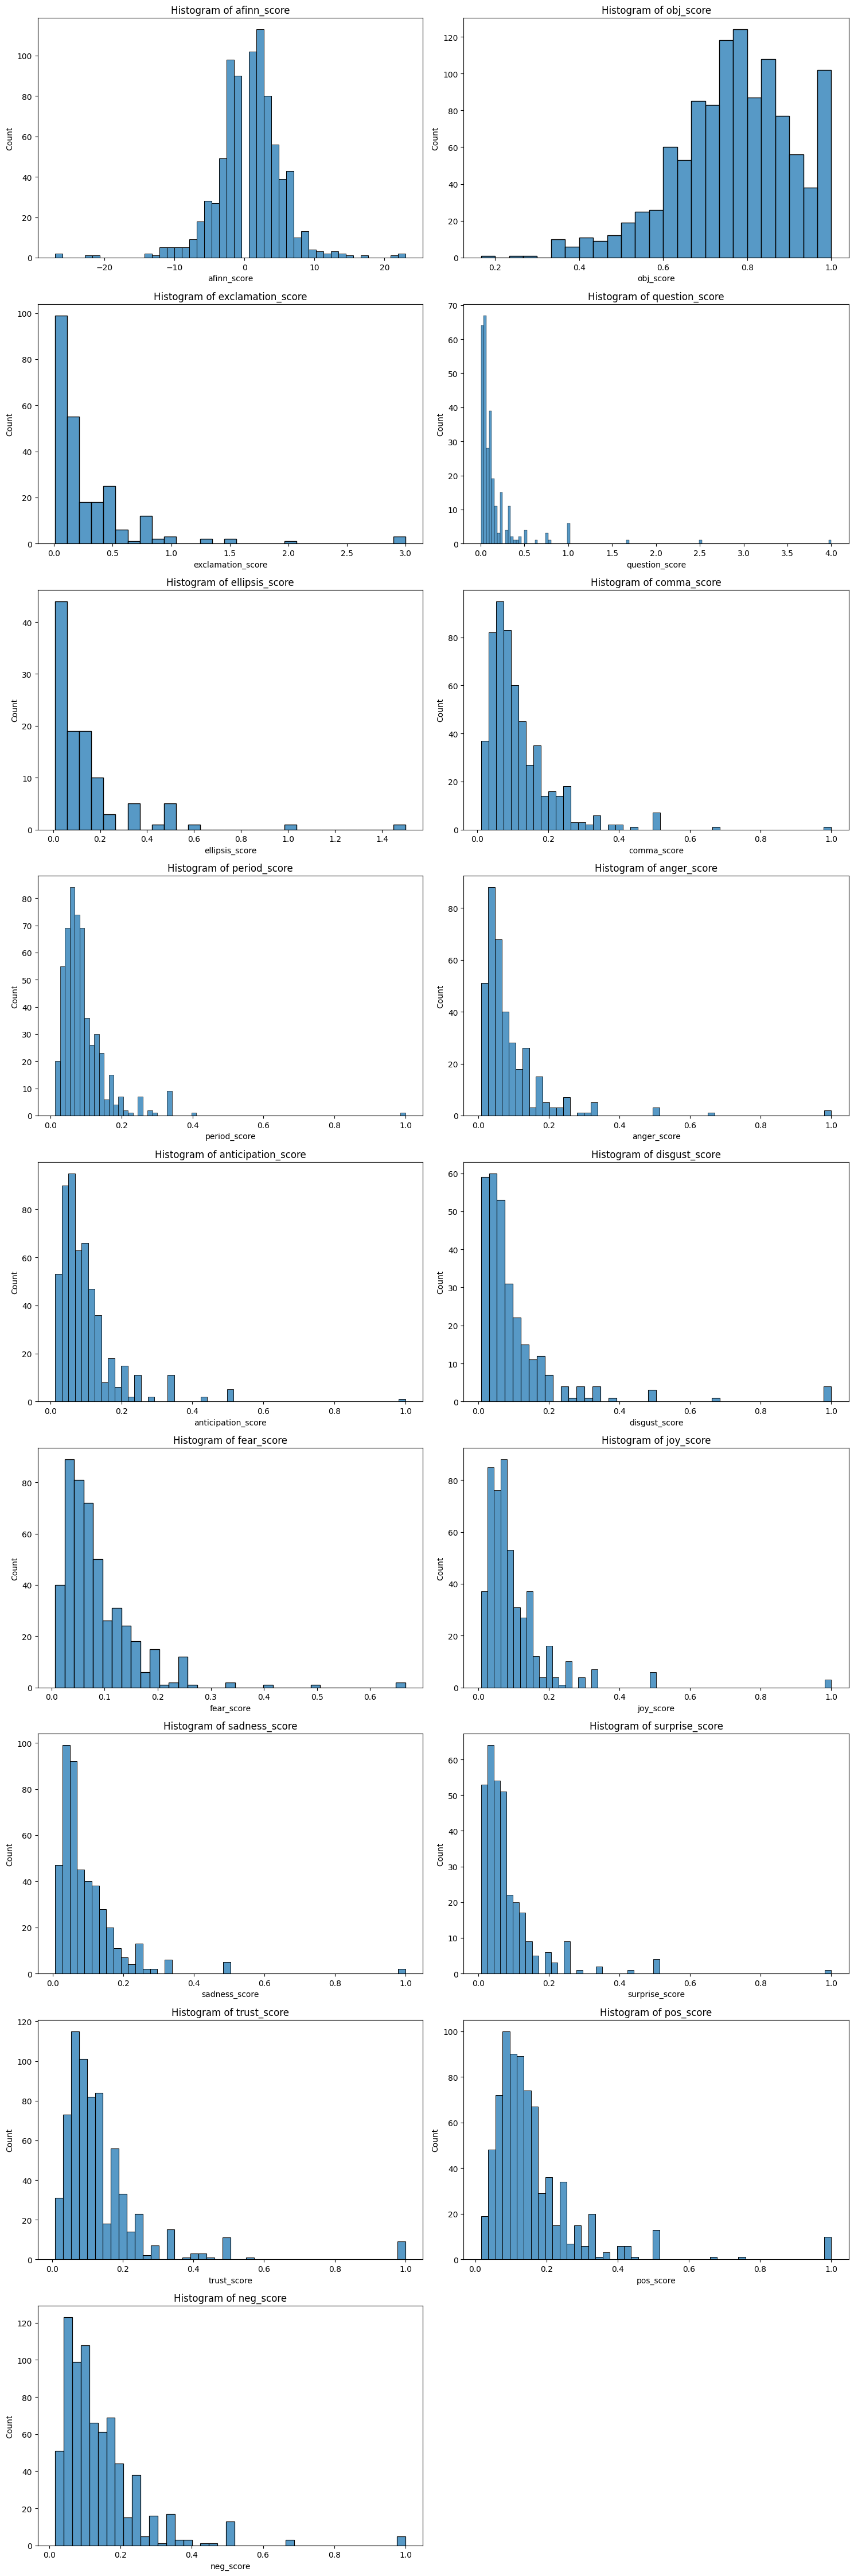

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

score_columns = [col for col in processed_data.columns if col.endswith('_score')]

# Step 2: Set up the grid layout
num_columns = 2  # Number of plots per row
num_plots = len(score_columns)
num_rows = (num_plots + num_columns - 1) // num_columns  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Step 3: Plot each histogram
for i, col in enumerate(score_columns):
    row = i // num_columns
    col_index = i % num_columns
    non_zero_data = processed_data[col][processed_data[col] != 0]
    #use processed_data[col] instead of non_zero_data
    sns.histplot(non_zero_data, ax=axes[row, col_index])
    axes[row, col_index].set_title(f'Histogram of {col}')

# If the number of plots is odd, remove the empty subplot
if num_plots % num_columns != 0:
    fig.delaxes(axes[num_rows-1, num_columns-1])

plt.tight_layout()
plt.show()

In [ ]:
# Create fuzzy logic hear based on the distributions above 

import numpy as np
import skfuzzy as fuzz

#### The Below is currently crap ####

# Define ranges for punctuation counts
punctuation_range = np.arange(0, 10, 1)

# Define membership functions
low_exclamation = fuzz.trimf(punctuation_range, [0, 0, 3])
high_exclamation = fuzz.trimf(punctuation_range, [3, 7, 10])

low_question = fuzz.trimf(punctuation_range, [0, 0, 2])
high_question = fuzz.trimf(punctuation_range, [2, 5, 10])

low_ellipsis = fuzz.trimf(punctuation_range, [0, 0, 1])
high_ellipsis = fuzz.trimf(punctuation_range, [1, 3, 10])

low_comma = fuzz.trimf(punctuation_range, [0, 0, 1])
high_comma = fuzz.trimf(punctuation_range, [1, 3, 10])

low_period = fuzz.trimf(punctuation_range, [0, 0, 1])
high_period = fuzz.trimf(punctuation_range, [1, 3, 10])